# Business Understanding

## Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### I'm intersting in building a model that predicts whether or not someone will respond to an offer. 

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [60]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sb





# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Understanding

In [61]:
portfolio.rename(columns = {'id':'offer_id'}, inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [62]:
profile.rename(columns = {'id':'customer_id'}, inplace=True)
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [63]:
transcript.query(" event == 'offer completed'")

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [64]:
portfolio.shape

(10, 6)

In [65]:
profile.shape

(17000, 5)

In [66]:
transcript.shape

(306534, 4)

## Data Preprocessing

### Profile

In [67]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [68]:
# Since there are 2175 recored are null I prefer to fill income with mean and gender with most frequint 
profile['income']=profile['income'].fillna(profile['income'].mean())
profile = profile.fillna(profile['gender'].value_counts().index[0])

In [69]:
profile.isnull().sum().any()

False

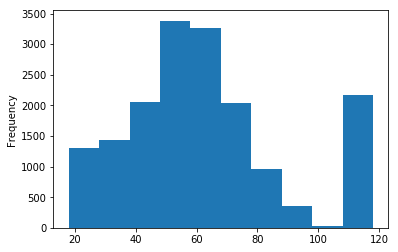

In [70]:
profile.age.plot(kind='hist');

There are about 2500 user above 110 years old which does not make sense, I will fill age column with mean since they seems to be outliers.

In [71]:
age_mean = profile['age'].mean()
profile['age'] = profile['age'].apply(lambda x : age_mean if x >= 110 else x)

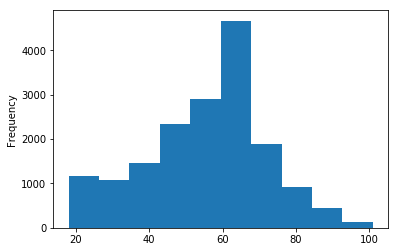

In [72]:
profile.age.plot(kind='hist');

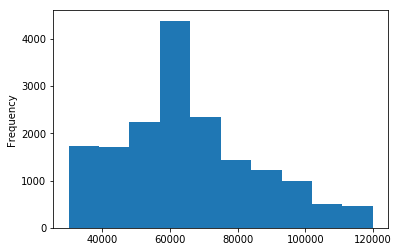

In [73]:
profile.income.plot(kind='hist');

In [74]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile.became_member_on = pd.DatetimeIndex(profile['became_member_on']).year

In [75]:
profile.sample()

,age,became_member_on,gender,customer_id,income
16972,44.0,2017,F,e2fd53ed790240c586b3188f23542cca,51000.0


### Portfolio

In [76]:
portfolio.isnull().sum().any()

False

In [77]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [18]:
#Splitting channels column to four columns, each value in one column 
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

#Dropping channels column
portfolio.drop(['channels'], axis=1, inplace=True)
portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


### Transcript

In [19]:
transcript.isnull().sum().any()

False

In [80]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [20]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [21]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [22]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [23]:
transcript_split = transcript['value'].apply(pd.Series)

In [24]:
#Splitting value column
transcript_split['offer_id_new']=np.where(transcript_split['offer id'].isnull() & transcript_split['offer_id'].notnull(),\
                                          transcript_split['offer_id'],
                                          transcript_split['offer id']
                                         )

In [25]:
transcript = pd.concat([transcript, transcript_split], axis=1)

In [26]:
#Dropping the unncessary columns
transcript = transcript.drop(['value','offer_id','offer id'], axis=1)

#Renaming the columns
transcript = transcript.rename(columns = {'person':'customer_id','offer_id_new':'offer_id','reward':'reward_complete'})

In [27]:
transcript["Days"] = transcript.time/24

In [28]:
transcript.drop(columns={'time'},inplace=True)

In [29]:
transcript['Days'] = transcript.Days.astype(int)

In [30]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
transcript.isnull().sum()

event                   0
customer_id             0
amount             167581
reward_complete    272955
offer_id           138953
Days                    0
dtype: int64

In [32]:
transcript['amount'] = transcript['amount'].fillna(value=0)

In [33]:
transcript['reward_complete'] = transcript['reward_complete'].fillna(value=0)


<b>After I cleaned all the datasets I will join them.

In [34]:
portfolio_transcript = portfolio.merge(transcript, on='offer_id',how='left')

In [35]:
All_Data = portfolio_transcript.merge(profile, on='customer_id',how='left')

In [36]:
All_Data.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

## EDA

#### What types of offers starbucks is offering? and how many are they?

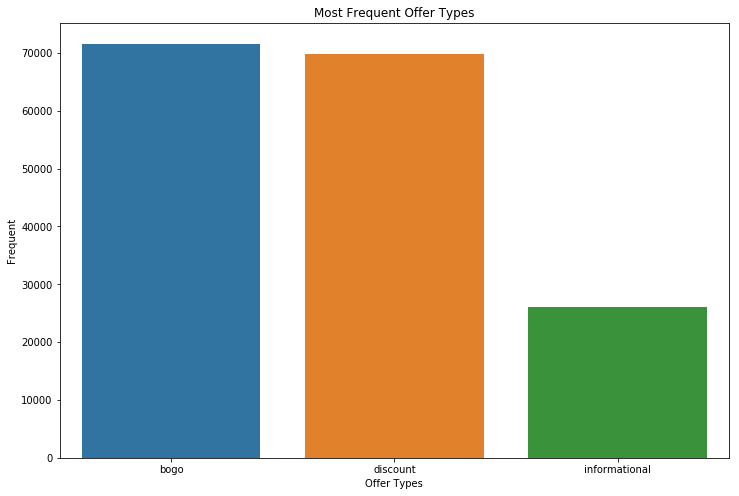

In [37]:
temp = All_Data.offer_type.value_counts().index #temp used in only this cell
plt.figure(figsize=(12,8))
sb.countplot(data=All_Data, x='offer_type', order=temp )
plt.title('Most Frequent Offer Types')
plt.xlabel('Offer Types')
plt.ylabel('Frequent');

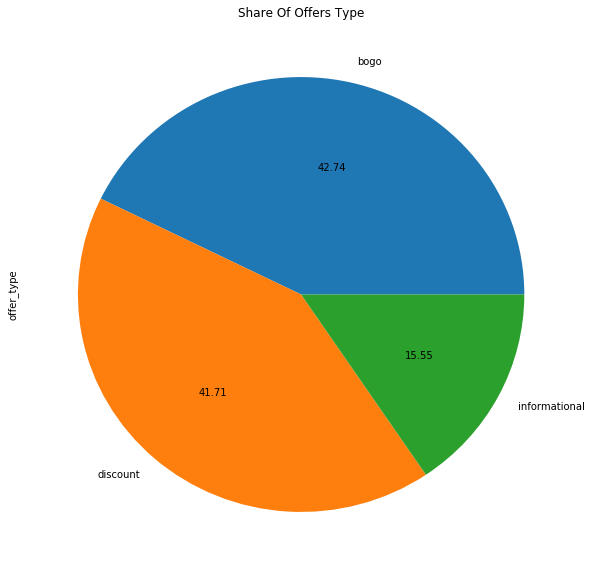

In [57]:
All_Data.offer_type.value_counts().plot(kind='pie',autopct='%0.2f' ,figsize=(10,10),title='Share Of Offers Type');

As shown above, Highest offer types offered by starbucks is BOGO. and starbucks has offered above 71000 of BOGO offer. which represant 42% from the total.

#### How users interact with starbucks offers?

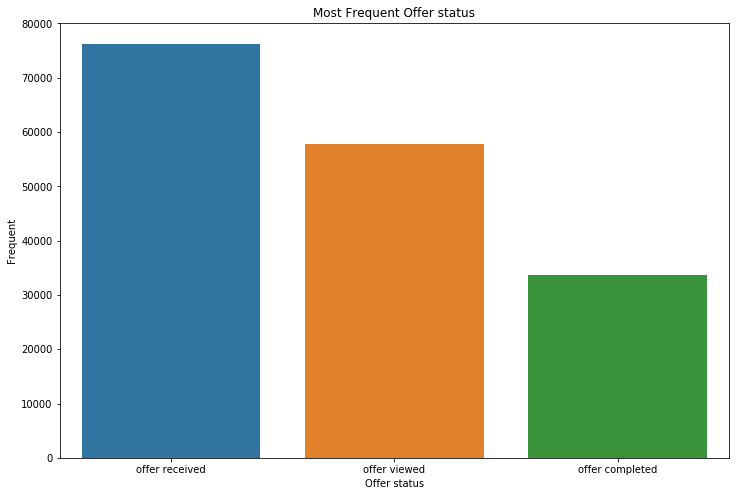

In [81]:
temp = All_Data.event.value_counts().index #temp used in only this cell
plt.figure(figsize=(12,8))
sb.countplot(data=All_Data, x='event', order=temp )
plt.title('Most Frequent Offer status')
plt.xlabel('Offer status')
plt.ylabel('Frequent');

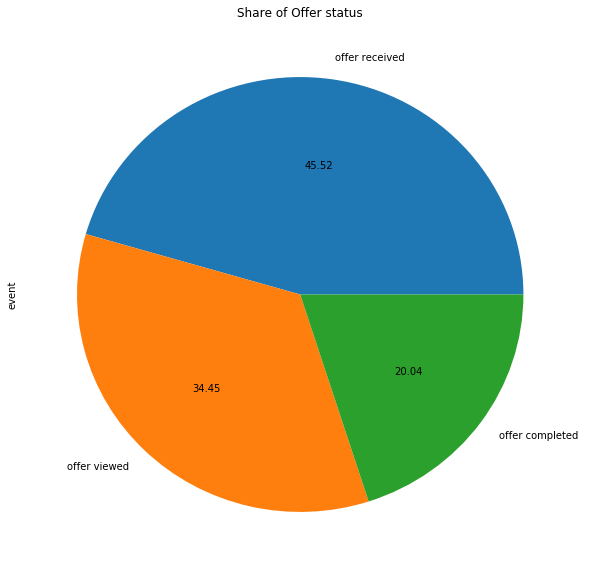

In [82]:
All_Data.event.value_counts().plot(kind='pie',autopct='%0.2f' ,figsize=(10, 10),title='Share of Offer status');

As shown above, Highest status is offer received which means that unfortunately the customers did not see the offer at all. which represents 45% from the total. 

### I'm targeting people who responds to the offers and visit starbucks to purchase.

In [83]:
event_values = All_Data.event.value_counts()

In [84]:
gender_values = All_Data.gender.value_counts()

In [85]:
offer_type_values = All_Data.offer_type.value_counts()

In [86]:
def Convert_Values(V1,V2,V3,Col):
    All_Data[V1] = Col.apply(lambda x: 1 if V1 in x else 0)
    All_Data[V2] = Col.apply(lambda x: 1 if V2 in x else 0)
    All_Data[V3] = Col.apply(lambda x: 1 if V3 in x else 0)

    All_Data.drop(columns={Col.name},inplace=True)

In [87]:
All_Data.head()

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social,event,customer_id,amount,reward_complete,Days,age,became_member_on,gender,income
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.0,0,64.0,2017,M,100000.0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,1e9420836d554513ab90eba98552d0a9,0.0,0.0,0,22.0,2017,M,70000.0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,02c083884c7d45b39cc68e1314fec56c,0.0,0.0,0,20.0,2016,F,30000.0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,676506bad68e4161b9bbaffeb039626b,0.0,0.0,0,37.0,2017,M,92000.0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,fe8264108d5b4f198453bbb1fa7ca6c9,0.0,0.0,0,78.0,2016,F,93000.0


In [88]:
Convert_Values(gender_values.index[0],gender_values.index[1],gender_values.index[2],All_Data['gender'])

In [89]:
Convert_Values(event_values.index[0],event_values.index[1],event_values.index[2],All_Data['event'])

In [90]:
Convert_Values(offer_type_values.index[0],offer_type_values.index[1],offer_type_values.index[2],All_Data['offer_type'])

In [91]:
All_Data.rename(columns={'offer viewed':'offer_viewed','offer completed':'offer_completed','offer received':'offer_received'},inplace=True)

In [92]:
All_Data['customer_response'] = All_Data['offer_viewed'] + All_Data['offer_completed']

In [93]:
All_Data['customer_response'].value_counts()

1    91304
0    76277
Name: customer_response, dtype: int64

In [94]:
All_Data.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'web', 'email',
       'mobile', 'social', 'customer_id', 'amount', 'reward_complete', 'Days',
       'age', 'became_member_on', 'income', 'M', 'F', 'O', 'offer_received',
       'offer_viewed', 'offer_completed', 'bogo', 'discount', 'informational',
       'customer_response'],
      dtype='object')

In [95]:
All_Data = All_Data.drop(['reward'], axis=1)

In [96]:
All_Data.reward_complete.value_counts()

0.0     134002
5.0      12070
2.0       9334
10.0      7019
3.0       5156
Name: reward_complete, dtype: int64

In [97]:
All_Data.became_member_on = All_Data.became_member_on.astype(str)

## Building Model

In [98]:
def classification_report_print(y_test,y_pred): 

    #Printing classification report for each class
    print(classification_report(y_test, y_pred))

    #Calculating the accuracy for the model    
    accuracy_model = (y_pred == y_test.values).mean()
    print("The model accuracy is:")
    print(accuracy_model)
    
def get_accuracy(y_test,y_pred):
    accuracy_model = (y_pred == y_test.values).mean()
    return accuracy_model

In [99]:
#splitting the dataframe into features and target
features = All_Data.drop(['customer_response','offer_id','customer_id','offer_viewed','offer_completed','offer_received','income','became_member_on'], axis=1)
label = All_Data['customer_response']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(features,label, test_size=0.25)

In [101]:
model_RandomForest = RandomForestClassifier(random_state=42)

#Fiting the model and predicting
y_pred = model_RandomForest.fit(X_train, y_train).predict(X_test)
classification_report_print(y_test,y_pred)
model_RandomForest_accuracy = get_accuracy(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.67      0.89      0.76     19150
          1       0.87      0.64      0.74     22746

avg / total       0.78      0.75      0.75     41896

The model accuracy is:
0.751288905862


In [102]:
model_DecisionTree = DecisionTreeClassifier(random_state=42)

#Fiting the model and predicting
y_pred = model_DecisionTree.fit(X_train, y_train).predict(X_test)
classification_report_print(y_test,y_pred)
model_model_DecisionTree = get_accuracy(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.68      0.93      0.79     19150
          1       0.92      0.63      0.75     22746

avg / total       0.81      0.77      0.76     41896

The model accuracy is:
0.767519572274


In [103]:
model_LogisticRegression = LogisticRegression(random_state=42)
y_pred = model_LogisticRegression.fit(X_train, y_train).predict(X_test)

classification_report_print(y_test,y_pred)
model_model_LogisticRegression = get_accuracy(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.59      0.85      0.69     19150
          1       0.80      0.49      0.61     22746

avg / total       0.70      0.66      0.65     41896

The model accuracy is:
0.658105785755


In [104]:
model_KNN = KNeighborsClassifier()
y_pred = model_KNN.fit(X_train, y_train).predict(X_test)

classification_report_print(y_test,y_pred)
model_KNN_accuracy = get_accuracy(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.65      0.80      0.72     19150
          1       0.79      0.64      0.71     22746

avg / total       0.73      0.71      0.71     41896

The model accuracy is:
0.711905671186


In [105]:
data = {'Name': ['RandomForest', 'DecisionTree', 'LogisticRegression', 'KNN'], 'Accuracy': [model_RandomForest_accuracy, model_model_DecisionTree, model_model_LogisticRegression, model_KNN_accuracy]}
Model_Info = pd.DataFrame(data)

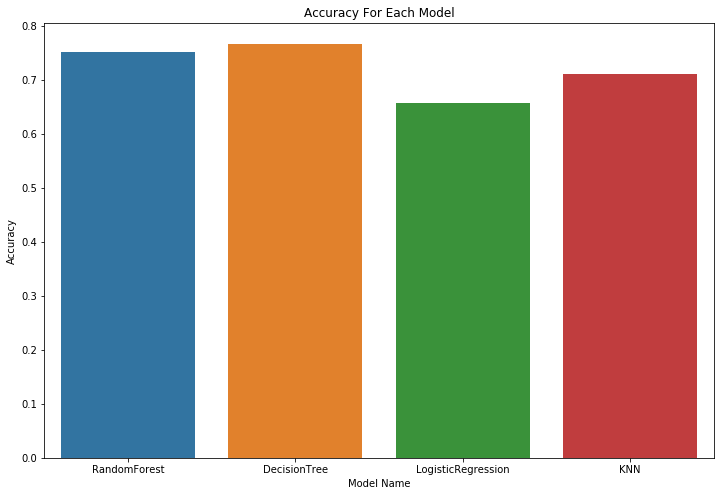

In [106]:
plt.figure(figsize=(12,8))
sb.barplot(data=Model_Info, x='Name',y='Accuracy')
plt.title('Accuracy For Each Model')
plt.xlabel('Model Name')
plt.ylabel('Accuracy');

As the plot above shown Decision Tree model has the heighst accuracy. 

### Tuning Best Model

In [107]:
model_DecisionTree.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [108]:
#Identifing the parameters 
parameters = {  'class_weight': [None],
                 'criterion': ['gini'],
                 'max_depth': [None],
                 'max_features': [None],
                 'max_leaf_nodes': [None],
                 'min_impurity_decrease': [0.0],
                 'min_impurity_split': [None],
                 'min_samples_leaf': [1],
                 'min_samples_split': [2],
                 'min_weight_fraction_leaf':[0.0],
                 'presort': [False],
                 'random_state': [42],
                 'splitter': ['best']
             }


cv = GridSearchCV(model_DecisionTree, param_grid=parameters)
cv

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'class_weight': [None], 'criterion': ['gini'], 'max_depth': [None], 'max_features': [None], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'min_weight_fraction_leaf': [0.0], 'presort': [False], 'random_state': [42], 'splitter': ['best']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [109]:
classification_report_print(y_test,cv.fit(X_train, y_train).predict(X_test))

             precision    recall  f1-score   support

          0       0.68      0.93      0.79     19150
          1       0.92      0.63      0.75     22746

avg / total       0.81      0.77      0.76     41896

The model accuracy is:
0.767519572274


In [110]:
cv.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}


    
## Conclusion/Reflection
I was interested to know what are the features that effecting customer decision to response to Starbucks offers. So, I built multiple models such as KNN, Random Forest and Decision Tree to predict whether the new customers will responds to Starbucks offers or not. Where the best model accuracy was Decision tree with 77% accuracy.
Some difficulties I faced:
regarding the data set It was not easy to prepare and a little bit tricky, that what make it more interesting to investigate. 
Choosing the right models.



## Improvement

Due to time limitation I couldn't able to investigate more to find out what are the best features that might effect customers response to get accuracy above 95%.
    
I believe there chance to improve the models by preparing the dataset by using the One Hot Encoding for all the columns that may improve accuracy.<br>
I believe there chance to improve the models performance by changing the features selected to predict the class label "customer_response". for example creating new features or dropping some of them.